<a href="https://colab.research.google.com/github/LexPaulus/Deep_Python/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение. Постановка целей и задач.

**Цель** исследования - прогноз цены открытия на основании исторических данных

**Задачи** исследования: 
- Исследование данных;
- Построение модели;
- Обучение модели SARIMAX;
- Создание прогноза;
- Сравнение прогноза и предсказания; 
- Расчет качества полученной модели и прогноза при помощи метрик качества;
- Анализ выводов по прогнозу.


### Импорт Датафрейма, библиотек, написание функций.

In [ ]:
# импортируем библиотеки и функции 
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# импортируем данные, создаем их копию 
df_original=pd.read_csv('binance_btcusdt_kline_1m.csv')
df=df_original
df.head()

,t,o,h,l,c,v
0,1609430400000,28782.01,28821.85,28763.94,28811.85,95.835795
1,1609430460000,28812.64,28822.59,28714.29,28726.62,58.516227
2,1609430520000,28728.28,28744.76,28684.69,28693.37,75.038373
3,1609430580000,28693.37,28715.15,28682.09,28690.29,37.128193
4,1609430640000,28690.29,28734.70,28680.00,28715.11,38.411112


Датасет представляет собой исторический срез курса обмена криптовалют BTC/USDT за период с 31.12.2020 (четверг) 16:00:00 по 05.12.2021 (воскресенье) 15:59:00







Описание столбцов:
 
t: Unix timestamp - временная метка операции, количество секунд, прошедших с начала  «эпохи Unix», т.е. с полуночи (00:00:00 UTC) 1 января 1970 года (четверг). 
Период взят в интерпретации сайта https://www.unixtimestamp.com, а не в интерпретации kaggle. 

o: Opening price on the given day (цена открытия в определенный день)

h: Highest price on the given day (наивысшая цена в определенный день)

l: Lowest price on the given day (низшая цена в определенный день)

c: Closing price on the given day (цена закрытия в определенный день)

v: Volume of transactions on the given day (объем транзакций за определенный день)

### Знакомство с данными.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487167 entries, 0 to 487166
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   t       487167 non-null  int64  
 1   o       487167 non-null  float64
 2   h       487167 non-null  float64
 3   l       487167 non-null  float64
 4   c       487167 non-null  float64
 5   v       487167 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 22.3 MB


Датафрейм содержит 487167 вхождений (записей), состоит из 6 столбцов (1-ый имеет тип int64, остальные - float64)

In [ ]:
#кол-во строк и столбцов таблицы
df.shape

(487167, 6)

In [ ]:
# описательная статистика
df.describe()

,t,o,h,l,c,v
count,4.871670e+05,487167.000000,487167.000000,487167.000000,487167.00000,487167.000000
mean,1.624078e+12,47238.594676,47275.039187,47202.242693,47238.63280,50.466159
std,8.458590e+09,10193.460108,10193.563030,10192.774762,10193.43637,65.723221
min,1.609430e+12,28241.950000,28372.440000,28130.000000,28235.47000,0.000000
25%,1.616748e+12,37427.805000,37472.975000,37384.350000,37427.96500,19.370902
50%,1.624082e+12,47659.520000,47692.240000,47628.220000,47659.54000,32.364667
75%,1.631405e+12,56630.990000,56669.990000,56591.625000,56631.13000,56.805935
max,1.638720e+12,69000.000000,69000.000000,68786.700000,69000.00000,2636.713888


In [ ]:
# вывод названий столбцов
df.columns

Index(['t', 'o', 'h', 'l', 'c', 'v'], dtype='object')

In [ ]:
# Для каждого столбца выведем: количество уникальных значений, нулевых, NaNs и их долю, а также тип данных в столбцах.
from tabulate import tabulate
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

# видим, что нет пропусков, можно продолжать работу с датафреймом без восполнения пробелов. Как таковой предообработки не требуется

| Column   |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|----------+----------------+---------------+--------------+-------------+-------------|
| t        |         487167 |             0 |            0 |           0 | int64       |
| o        |         432648 |             0 |            0 |           0 | float64     |
| h        |         397687 |             0 |            0 |           0 | float64     |
| l        |         400694 |             0 |            0 |           0 | float64     |
| c        |         432511 |             0 |            0 |           0 | float64     |
| v        |         483569 |            89 |            0 |           0 | float64     |


In [ ]:
# т.к. дата представлена в виде временной метки Unix, необходимо ее преобразовать в формат даты
df['t'] = pd.to_datetime(df['t'], unit="ms")
df

,t,o,h,l,c,v
0,2020-12-31 16:00:00,28782.01,28821.85,28763.94,28811.85,95.835795
1,2020-12-31 16:01:00,28812.64,28822.59,28714.29,28726.62,58.516227
2,2020-12-31 16:02:00,28728.28,28744.76,28684.69,28693.37,75.038373
3,2020-12-31 16:03:00,28693.37,28715.15,28682.09,28690.29,37.128193
4,2020-12-31 16:04:00,28690.29,28734.70,28680.00,28715.11,38.411112
...,...,...,...,...,...,...
487162,2021-12-05 15:55:00,47922.76,47996.00,47907.21,47989.99,64.311240
487163,2021-12-05 15:56:00,47990.00,48000.00,47933.44,47946.65,71.669860
487164,2021-12-05 15:57:00,47946.65,47992.39,47900.00,47980.24,50.819920
487165,2021-12-05 15:58:00,47980.25,47980.99,47902.58,47912.90,41.794080


In [ ]:
# установим дату как индекс
df.set_index('t', inplace=False) 
df.index.freq='MS'
df.head()

,t,o,h,l,c,v
0,2020-12-31 16:00:00,28782.01,28821.85,28763.94,28811.85,95.835795
1,2020-12-31 16:01:00,28812.64,28822.59,28714.29,28726.62,58.516227
2,2020-12-31 16:02:00,28728.28,28744.76,28684.69,28693.37,75.038373
3,2020-12-31 16:03:00,28693.37,28715.15,28682.09,28690.29,37.128193
4,2020-12-31 16:04:00,28690.29,28734.70,28680.00,28715.11,38.411112


[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

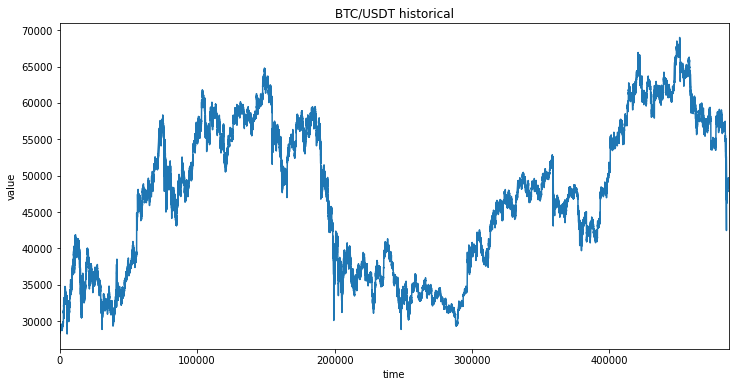

In [ ]:
# представим данные графически, применительно к каждому показателю
xtitle='BTC/USDT historical'
ylabel='value'
xlabel='time'

ax=df['o'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True) 

ax.set(xlabel=xlabel, ylabel=ylabel)

[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

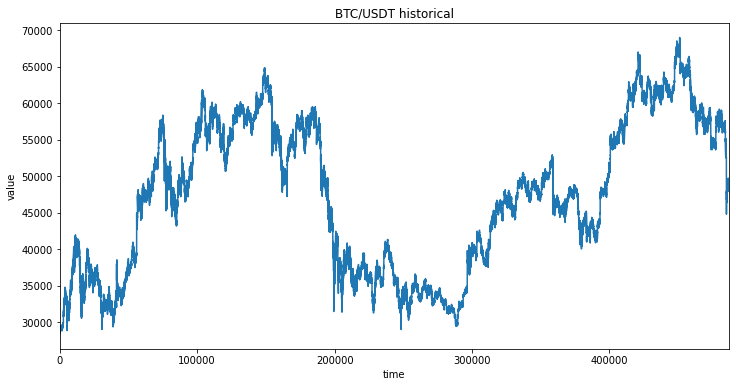

In [ ]:
ax=df['h'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

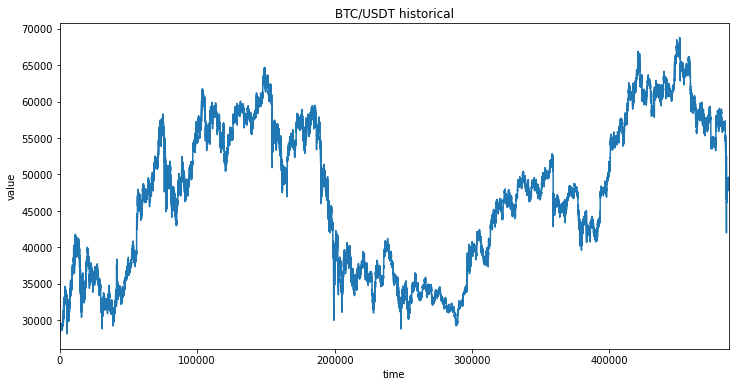

In [ ]:
ax=df['l'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

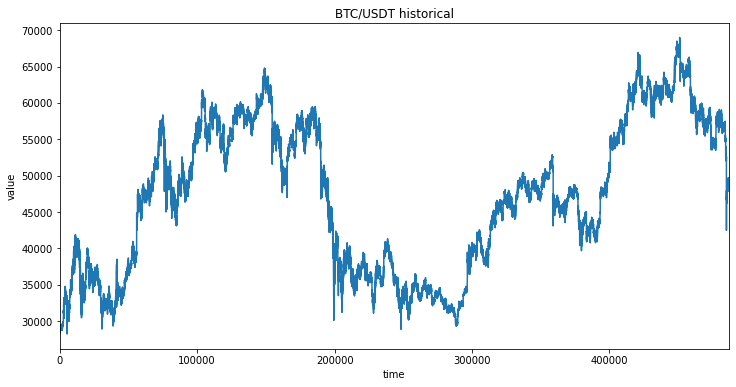

In [ ]:
ax=df['c'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Все четыре параметра идентичны, тренды совпадают. 
Сезонности нет, поскольку временной отрезок - менее года


[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

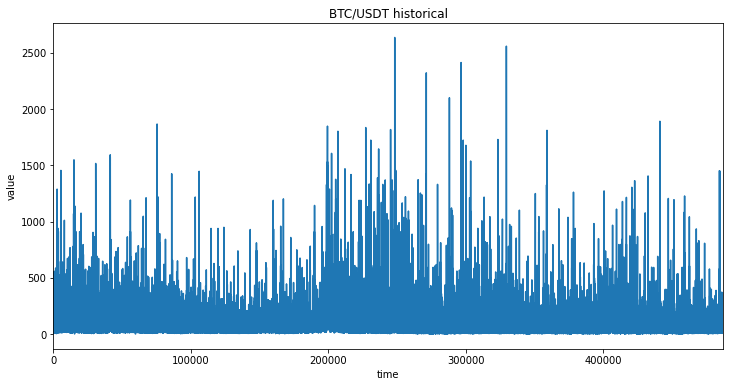

In [ ]:
# график временного ряда для объема транзакций
ax=df['v'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel) 

[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

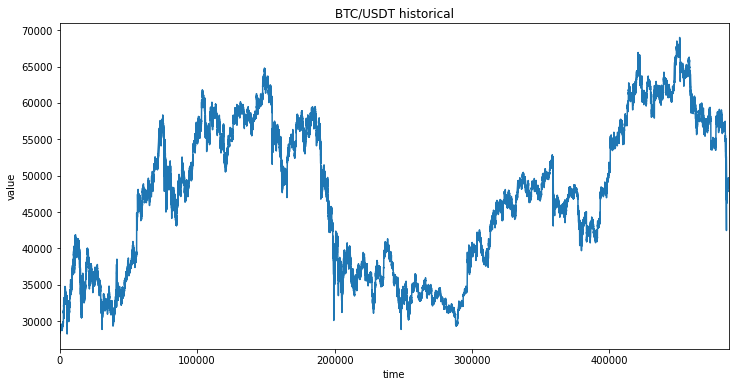

In [ ]:
# для исследования выберем параметр цены открытия, построим график для него 
xtitle='BTC/USDT historical'
ylabel='value'
xlabel='time'

ax=df['o'].plot(figsize=(12,6), title=xtitle) 
ax.autoscale(axis='x',tight=True) 

ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# cледует разделить столбец даты, отделить от него время
df['Date'] = df['t'].dt.date
df['Time'] = df['t'].dt.time
df.head()

,t,o,h,l,c,v,Date,Time
0,2020-12-31 16:00:00,28782.01,28821.85,28763.94,28811.85,95.835795,2020-12-31,16:00:00
1,2020-12-31 16:01:00,28812.64,28822.59,28714.29,28726.62,58.516227,2020-12-31,16:01:00
2,2020-12-31 16:02:00,28728.28,28744.76,28684.69,28693.37,75.038373,2020-12-31,16:02:00
3,2020-12-31 16:03:00,28693.37,28715.15,28682.09,28690.29,37.128193,2020-12-31,16:03:00
4,2020-12-31 16:04:00,28690.29,28734.70,28680.00,28715.11,38.411112,2020-12-31,16:04:00


In [ ]:
# cгруппируем данные по дате и выведем среднее по отдельным дням
df_groupped = df.groupby('Date').mean()
df_groupped

,o,h,l,c,v
Date,,,,,
2020-12-31,28856.863604,28872.433854,28839.355250,28857.100021,37.823038
2021-01-01,29212.370965,29227.985236,29195.374562,29212.610701,37.627031
2021-01-02,30693.657375,30725.315458,30660.577542,30695.574403,90.273523
2021-01-03,33448.355861,33489.457715,33405.464875,33448.991854,83.998310
2021-01-04,31826.882174,31878.486146,31773.153313,31826.140382,97.847143
...,...,...,...,...,...
2021-12-01,57355.024056,57392.058590,57318.547785,57355.191785,31.219886
2021-12-02,56654.304111,56689.727486,56619.340458,56653.824271,26.093097
2021-12-03,55832.471910,55870.960528,55790.326847,55830.511861,40.922007


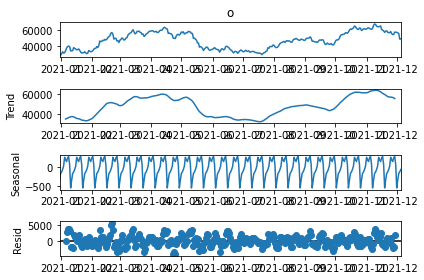

In [ ]:
# ETS декомпозиция
import matplotlib.pyplot as plt
decomp=seasonal_decompose(df_groupped['o'], model='add', period=12)
decomp.plot()
plt.tight_layout()

In [ ]:
#выведем корреляцию по всем параметрам
df.corr()

,o,h,l,c,v
o,1.000000,0.999989,0.999989,0.999983,-0.161464
h,0.999989,1.000000,0.999980,0.999990,-0.159233
l,0.999989,0.999980,1.000000,0.999990,-0.163823
c,0.999983,0.999990,0.999990,1.000000,-0.161542
v,-0.161464,-0.159233,-0.163823,-0.161542,1.000000


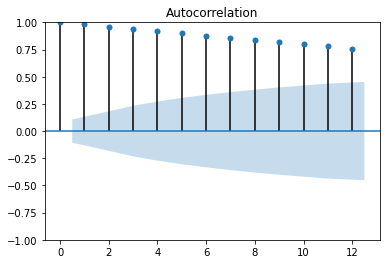

In [ ]:
# построение графиков автокорреляции (ACF) и частичной автокорреляции (РACF)
from matplotlib import pyplot
plot_acf(df_groupped['o'], lags=12)
pyplot.show()

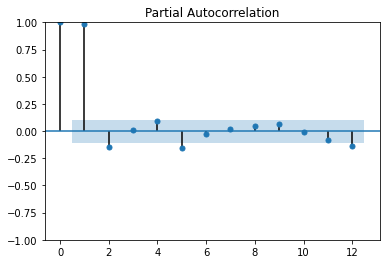

In [ ]:
plot_pacf(df_groupped['o'], lags=12)
pyplot.show()

Автокореляция показывает насколько данные за сегодня коррелируют с данными за прошлые дни

Частичная корреляция показывает насколько данные на день зависят от других дней | Стабильность кореляции во времени (сколько шагов назад кореляция была стабильна)

По графику видно что корреляция сохраняется вплоть до 12 лагов, в отличии от частичной корреляции

In [ ]:
# Запускаем auto_arima чтобы получить набор гиперпараметров
auto_arima(df_groupped['o'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  340
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2984.412
Date:                Sun, 12 Feb 2023   AIC                           5972.823
Time:                        06:36:31   BIC                           5980.475
Sample:                    12-31-2020   HQIC                          5975.872
                         - 12-05-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1136      0.044      2.562      0.010       0.027       0.201
sigma2      2.585e+06   1.44e+05     17.986      0.000     2.3e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                86.84
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.67
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Подбор параметров выдал наилучшую модель: SARIMAX(1, 1, 0) AIC=5972.823. 
Также видно, что **нет сезонного компонента.** 

In [ ]:
# Определим длину датафрейма 
len(df_groupped)

340

In [ ]:
# Разделим данные на test и train. Установим последние 12 записей в качестве тестовой выборки
train=df_groupped.iloc[:328]
test=df_groupped.iloc[328:]

In [ ]:
#Обучим метод SARIMA с полученными гиперпараметрами на train выборке и выведем summary получившегося результата (нет сезонной компоненты)
model=SARIMAX(train['o'], order=(1, 1, 0)) 
results=model.fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      o   No. Observations:                  328
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2871.592
Date:                Sun, 12 Feb 2023   AIC                           5747.184
Time:                        06:37:22   BIC                           5754.764
Sample:                    12-31-2020   HQIC                          5750.208
                         - 11-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.042      2.803      0.005       0.036       0.201
sigma2      2.471e+06   1.48e+05     16.691      0.000    2.18e+06    2.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                52.65
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Модель показала хороший результат: параметр P>|z| не превышает 0.5

In [ ]:
# Получаем прогнозируемые значения 
xstart=len(train)
xend=len(train)+len(test)-1

predictions=results.predict(start=xstart, end=xend, dynamic=False, typ='levels').rename('Предсказание SARIMAX')

for i in range(len(predictions)):
  print(f"predicted={predictions[i]:<11.10}, expected={test['o'][i]}")

predicted=56853.98855, expected=56737.20593055556
predicted=56848.07819, expected=58231.51722222222
predicted=56847.37809, expected=55648.149798611106
predicted=56847.29516, expected=54642.17270833334
predicted=56847.28533, expected=54583.04641666667
predicted=56847.28417, expected=57550.39461111111
predicted=56847.28403, expected=57308.40227083333
predicted=56847.28402, expected=57355.02405555556
predicted=56847.28401, expected=56654.30411111111
predicted=56847.28401, expected=55832.47190972222
predicted=56847.28401, expected=48963.6390625
predicted=56847.28401, expected=49137.93721875


[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

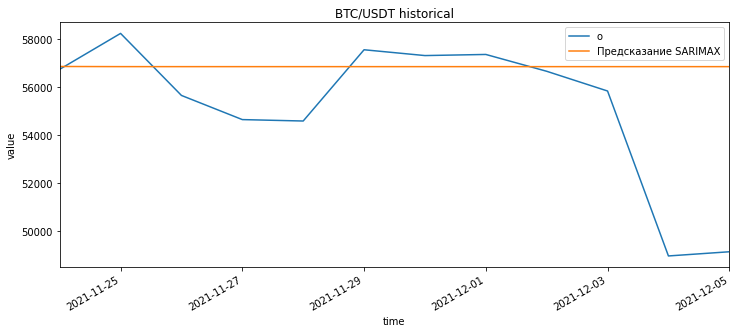

In [ ]:
# строим графики прогнозируемых и известных значений
xtitle='BTC/USDT historical'
ylabel='value'
xlabel='time'

ax=test['o'].plot(legend=True, figsize=(12,5), title=xtitle)
predictions.plot(legend=True)

ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# Оцениваем качество модели с помощью MSE и RMSE. 
from sklearn.metrics import mean_squared_error 
error=mean_squared_error(test['o'], predictions)  

print(f'SARIMAX(1, 1, 0) MSE Error: {error:11.10}')  

SARIMAX(1, 1, 0) MSE Error: 11414399.83


In [ ]:
from statsmodels.tools.eval_measures import rmse
error=rmse(test['o'], predictions)

print(f'SARIMAX(1, 1, 0) RMSE Error: {error:11.10}')

SARIMAX(1, 1, 0) RMSE Error: 3378.520361


In [ ]:
# Натренируем модель на полном датасете и предскажем на 20 дней вперед
xstart=len(df_groupped)
xend=len(df_groupped)+20

predictions=results.predict(start=xstart, end=xend, dynamic=False, typ='levels').rename('Предсказание SARIMAX')

for i in range(len(predictions)):
  print(f"predicted={predictions[i]:<11.10}, expected={df_groupped['o'][i]}") 

predicted=56847.28401, expected=28856.863604166665
predicted=56847.28401, expected=29212.370965277776
predicted=56847.28401, expected=30693.657375
predicted=56847.28401, expected=33448.35586111111
predicted=56847.28401, expected=31826.88217361111
predicted=56847.28401, expected=32221.226270833333
predicted=56847.28401, expected=34799.5521875
predicted=56847.28401, expected=38001.5138125
predicted=56847.28401, expected=39775.486375
predicted=56847.28401, expected=40327.461083333335
predicted=56847.28401, expected=39673.757284722225
predicted=56847.28401, expected=34320.95515277778
predicted=56847.28401, expected=34845.795173611106
predicted=56847.28401, expected=34691.61904861111
predicted=56847.28401, expected=38513.137875
predicted=56847.28401, expected=37494.27442361111
predicted=56847.28401, expected=36834.27
predicted=56847.28401, expected=35653.56417361111
predicted=56847.28401, expected=36043.3724375
predicted=56847.28401, expected=36826.25921527778
predicted=56847.28401, expecte

In [ ]:
model=SARIMAX(df_groupped['o'], order=(1, 1, 0))  
results=model.fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      o   No. Observations:                  340
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2984.412
Date:                Sun, 12 Feb 2023   AIC                           5972.823
Time:                        06:38:49   BIC                           5980.475
Sample:                    12-31-2020   HQIC                          5975.872
                         - 12-05-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1136      0.044      2.562      0.010       0.027       0.201
sigma2      2.585e+06   1.44e+05     17.986      0.000     2.3e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                86.84
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.67
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

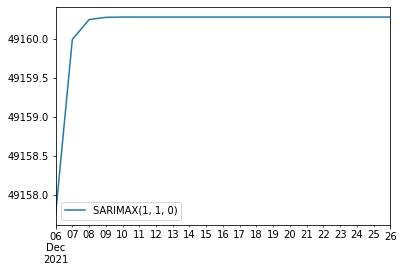

In [ ]:
#Построим график предсказания
fcast=results.predict(len(df_groupped), len(df_groupped) + 20, typ='levels').rename('SARIMAX(1, 1, 0)')
fcast.plot(legend=True)

[Text(0, 0.5, 'value'), Text(0.5, 0, 'time')]

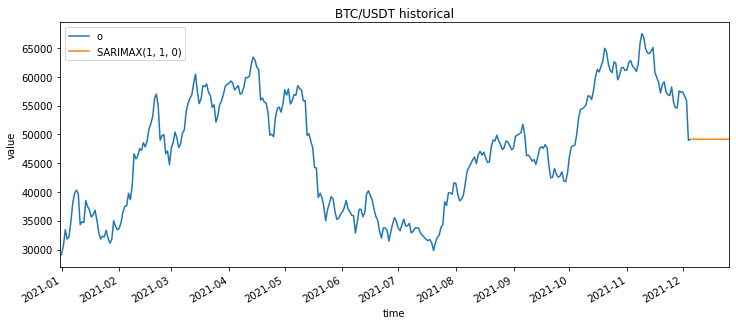

In [ ]:
#Построим график предсказаний и график исходных данных.
xtitle='BTC/USDT historical'
ylabel='value'
xlabel='time'

ax=df_groupped['o'].plot(legend=True, figsize=(12,5), title=xtitle)
fcast.plot(legend=True)

ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

## Выводы

Ошибка слишком велика. Вследствие отсутствия фактора сезонности, модель SARIMAX не подходит для предсказания по исходным данным.  
Вероятно, стоит уменьшить либо увеличить количество наблюдений либо использовать другую модель.